In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
import logging

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

import csv
import argparse
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
from models import networks
from configs.base import Config
from collections import Counter
from typing import Tuple


In [2]:
def calculate_accuracy(y_true, y_pred) -> Tuple[float, float]:
    class_weights = {cls: 1.0 / count for cls, count in Counter(y_true).items()}
    bacc = float(
        balanced_accuracy_score(
            y_true, y_pred, sample_weight=[class_weights[cls] for cls in y_true]
        )
    )
    acc = float(accuracy_score(y_true, y_pred))
    return bacc, acc


def calculate_f1_score(y_true, y_pred) -> Tuple[float, float]:
    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
    weighted_f1 = float(f1_score(y_true, y_pred, average="weighted"))
    return macro_f1, weighted_f1


def eval(cfg, checkpoint_path, all_state_dict=True, cm=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, cfg.model_type)(cfg)
    network.to(device)

    # Build dataset
    _, test_ds = build_train_test_dataset(cfg)
    weight = torch.load(checkpoint_path, map_location=torch.device(device))
    if all_state_dict:
        weight = weight["state_dict_network"]

    network.load_state_dict(weight)
    network.eval()
    network.to(device)

    y_actu = []
    y_pred = []

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            output = network(input_ids, audio)[0]
            _, preds = torch.max(output, 1)
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds.detach().cpu().numpy()[0])
    bacc, acc = calculate_accuracy(y_actu, y_pred)
    macro_f1, weighted_f1 = calculate_f1_score(y_actu, y_pred)
    if cm:
        cm = confusion_matrix(y_actu, y_pred)
        print("Confusion Matrix: \n", cm)
        cmn = (cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]) * 100

        ax = plt.subplots(figsize=(8, 5.5))[1]
        sns.heatmap(
            cmn,
            cmap="YlOrBr",
            annot=True,
            square=True,
            linecolor="black",
            linewidths=0.75,
            ax=ax,
            fmt=".2f",
            annot_kws={"size": 16},
        )
        ax.set_xlabel("Predicted", fontsize=18, fontweight="bold")
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.set_ticklabels(
            ["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16
        )
        ax.set_ylabel("Ground Truth", fontsize=18, fontweight="bold")
        ax.yaxis.set_ticklabels(
            ["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16
        )
        plt.tight_layout()
        plt.savefig(cfg.name + ".png", format="png", dpi=1200)

    return bacc, acc, macro_f1, weighted_f1

In [3]:
def evaluate(ckpt, test_set=None):
    cfg_path = os.path.join(ckpt, "cfg.log")
    all_state_dict = True
    ckpt_path = os.path.join(
        ckpt, "weights/best_acc/checkpoint_0_0.pt"
    )
    if not os.path.exists(ckpt_path):
        ckpt_path = os.path.join(
            ckpt, "weights/best_acc/checkpoint_0.pth"
        )
        all_state_dict = False
    
    cfg = Config()
    cfg.load(cfg_path)
    # Change to test set
    test_set = test_set if test_set is not None else "test.pkl"
    cfg.data_valid = test_set
    
    bacc, acc, macro_f1, weighted_f1 = eval(
        cfg,
        ckpt_path,
        all_state_dict=all_state_dict,
    )
    logging.info(
        "BACC {:.4f} | ACC {:.4f}, | MACRO_F1 {:.4f} | WEIGHTED_F1 {:.4f}".format(
            bacc, acc, macro_f1, weighted_f1
        )
    )
    return {"$BACC$":round(bacc*100,2), "$ACC$" :round(acc*100,2), "$MF1$":round(macro_f1*100,2), "$WF1$": round(weighted_f1*100,2)}

In [4]:
ckpt_3m_ser = "checkpoints_latest/IEMOCAP/_3M_SER_bert_vggish/20240317-093627"
ckpt_4m_ser = "checkpoints_latest/IEMOCAP/_4M_SER_bert_vggish/20240324-231013"

test_3m_ser = evaluate(ckpt_3m_ser)
eval_3m_ser = evaluate(ckpt_3m_ser, test_set="val.pkl")

test_4m_ser = evaluate(ckpt_4m_ser)
eval_4m_ser = evaluate(ckpt_4m_ser, test_set="val.pkl")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [5]:
eval_3m_ser, eval_4m_ser

({'$BACC$': 75.03, '$ACC$': 74.5, '$MF1$': 74.92, '$WF1$': 74.55},
 {'$BACC$': 76.12, '$ACC$': 75.5, '$MF1$': 75.97, '$WF1$': 75.49})

In [6]:
test_3m_ser, test_4m_ser

({'$BACC$': 76.77, '$ACC$': 76.53, '$MF1$': 77.06, '$WF1$': 76.79},
 {'$BACC$': 77.65, '$ACC$': 77.08, '$MF1$': 77.62, '$WF1$': 77.2})

/tmp/ipykernel_36507/2002435524.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


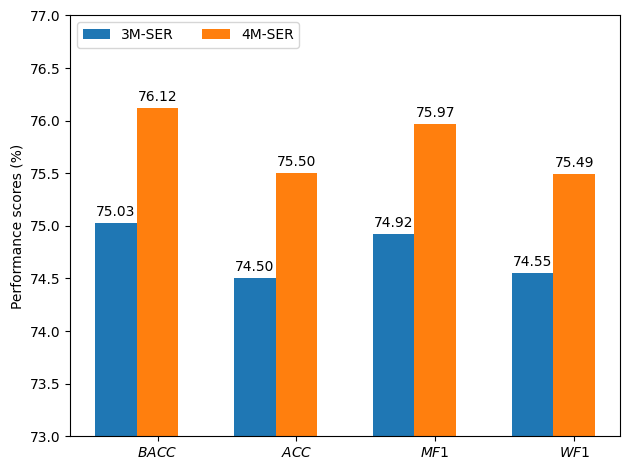

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

species = ('$BACC$', '$ACC$', '$MF1$', '$WF1$')
penguin_means = {
    "3M-SER": (eval_3m_ser['$BACC$'], eval_3m_ser['$ACC$'], eval_3m_ser['$MF1$'],eval_3m_ser['$WF1$']),
    "4M-SER": (eval_4m_ser['$BACC$'], eval_4m_ser['$ACC$'], eval_4m_ser['$MF1$'],eval_4m_ser['$WF1$']),
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fmt = lambda x, pos: '1+ {:.0f}e-3'.format((x-1)*1e3, pos)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='{:.2f}')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance scores (%)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(73, 77)

plt.tight_layout()
plt.savefig("3M-SERvs4M-SER_eval.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_36507/996657867.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


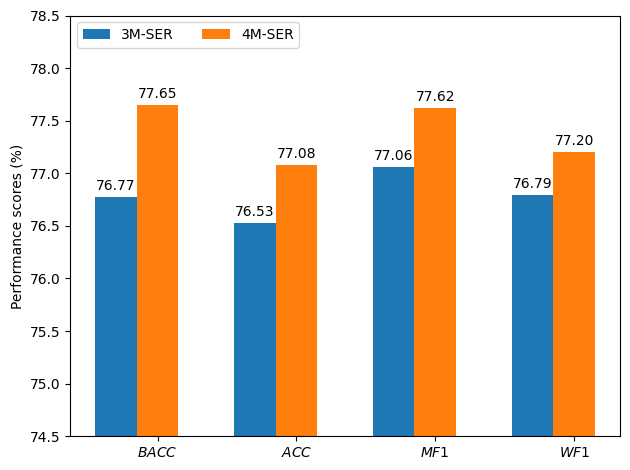

In [28]:
import matplotlib.pyplot as plt
import numpy as np

species = ('$BACC$', '$ACC$', '$MF1$', '$WF1$')
penguin_means = {
    "3M-SER": (test_3m_ser['$BACC$'], test_3m_ser['$ACC$'], test_3m_ser['$MF1$'],test_3m_ser['$WF1$']),
    "4M-SER": (test_4m_ser['$BACC$'], test_4m_ser['$ACC$'], test_4m_ser['$MF1$'],test_4m_ser['$WF1$']),
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='{:.2f}')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance scores (%)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(74.5, 78.5)

plt.tight_layout()
plt.savefig("3M-SERvs4M-SER_test.png", dpi=300, bbox_inches='tight')
plt.show()